In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
train_path = r'D:\thesis\filtered train'
val_path = r'D:\thesis\filtered validation'
test_path = r'D:\thesis\filtered test'

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_path, target_size=(224, 224), batch_size=16, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(
    val_path, target_size=(224, 224), batch_size=16, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
    test_path, target_size=(224, 224), batch_size=16, class_mode='categorical')

Found 3014 images belonging to 334 classes.
Found 680 images belonging to 334 classes.
Found 673 images belonging to 334 classes.


In [7]:
# Load ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(224, 224, 3))

# Adding custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(
    x)  # Ensure this matches the number of individuals

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(train_generator, validation_data=val_generator, epochs=50,
                    steps_per_epoch=len(train_generator), validation_steps=len(val_generator))

model.save('my_model3.h5')

# Evaluate model
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)

Epoch 1/50
189/189 [==============================] - 97s 483ms/step - loss: 4.6304 - accuracy: 0.1941 - val_loss: 6.4382 - val_accuracy: 0.0029
Epoch 2/50
189/189 [==============================] - 89s 468ms/step - loss: 0.9204 - accuracy: 0.8656 - val_loss: 7.1909 - val_accuracy: 0.0015
Epoch 3/50
189/189 [==============================] - 89s 469ms/step - loss: 0.0816 - accuracy: 0.9970 - val_loss: 8.4371 - val_accuracy: 0.0059
Epoch 4/50
189/189 [==============================] - 88s 467ms/step - loss: 0.0173 - accuracy: 0.9997 - val_loss: 9.4837 - val_accuracy: 0.0059
Epoch 5/50
189/189 [==============================] - 88s 466ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 6.8632 - val_accuracy: 0.0515
Epoch 6/50
189/189 [==============================] - 88s 467ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.2027 - val_accuracy: 0.7015
Epoch 7/50
189/189 [==============================] - 89s 470ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.1543 - val_ac

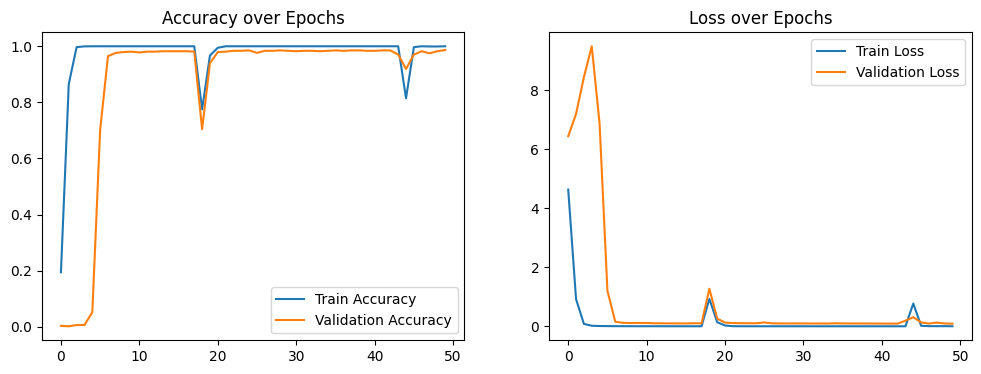

In [9]:
# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [10]:
val_accuracy = history.history['val_accuracy'][-1]
print(f"Validation Accuracy: {val_accuracy}")

Validation Accuracy: 0.9867647290229797


In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")

43/43 [==============================] - 6s 144ms/step - loss: 0.0454 - accuracy: 0.9896
Test Loss: 0.04544409364461899


In [10]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the model
model = tf.keras.models.load_model(r'D:\thesis\codes\my_model3.h5')

# Directory for test data
test_dir = r'D:\thesis\filtered test'

# Initialize counter for correct predictions
correct_predictions_count = 0

# Retrieve class labels from test_generator
class_labels = {v: k for k, v in test_generator.class_indices.items()}

# Loop through the test data
for class_label in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_label)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)

            # Load and preprocess the image
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0  # Rescale pixel values

            # Predict
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]
            predicted_class_label = class_labels[predicted_class]

            # Check if the prediction is correct and increment the counter
            if predicted_class_label == class_label:
                correct_predictions_count += 1

# Output the total number of correct predictions
print(f"Total correct predictions: {correct_predictions_count}")

1/1 [==============================] - 0s 23ms/step
Total correct predictions: 666


In [12]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the model
model = tf.keras.models.load_model(r'D:\thesis\codes\my_model3.h5')

# Directory for test data
test_dir = r'D:\thesis\filtered test'

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Loop through the test data
for class_label in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_label)
    if os.path.isdir(class_dir):
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)

            # Load and preprocess the image
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0  # Rescale pixel values

            # Predict
            prediction = model.predict(img_array)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # Append to lists
            true_labels.append(class_label)
            predicted_labels.append(predicted_class)

# Convert class labels to numeric values
label_to_index = test_generator.class_indices
index_to_label = dict((v, k) for k, v in label_to_index.items())
numeric_true_labels = [label_to_index[label] for label in true_labels]



from sklearn.metrics import f1_score
f1 = f1_score(numeric_true_labels, predicted_labels, average='micro')

print(f"F1 Score (Micro): {f1}")

f1 = f1_score(numeric_true_labels, predicted_labels, average='macro')

print(f"F1 Score (Macro): {f1}")

f1 = f1_score(numeric_true_labels, predicted_labels, average='weighted')

print(f"F1 Score (Weighted): {f1}")

1/1 [==============================] - 0s 22ms/step
F1 Score (Micro): 0.9895988112927192
F1 Score (Macro): 0.9893926432848589
F1 Score (Weighted): 0.988962003820845


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def evaluate_model(model, test_dir, batch_size=32):
    # Test data generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    # Evaluating the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

    # Predicting on the test set
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Precision and recall
    precision = tf.keras.metrics.Precision()
    recall = tf.keras.metrics.Recall()

    precision.update_state(true_classes, predicted_classes)
    recall.update_state(true_classes, predicted_classes)

    return precision.result().numpy(), recall.result().numpy(), test_loss, test_accuracy, class_labels


# Assuming 'model' is your trained Keras model and '/path_to_test_dataset/' is your test dataset directory
precision, recall, test_loss, test_accuracy, class_labels = evaluate_model(
    model, r'D:\thesis\filtered test')

# Printing results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print("Precision and Recall for each class:")
for i, label in enumerate(class_labels):
    print(f"{label}: Precision = {precision[i]}, Recall = {recall[i]}")

Found 673 images belonging to 334 classes.
22/22 [==============================] - 7s 298ms/step
Test Loss: 0.04544408246874809
Test Accuracy: 0.98959881067276
Precision and Recall for each class:


IndexError: invalid index to scalar variable.